In [1]:
import pandas as pd
from tools.metadata_tools import *
test = '../Results/json_detection'
train = '../Results/json_detection/train'
model = 'models/trainingJSON_2020-06-16_12:32:03'
from tensorflow.python.keras.models import model_from_json

matrix_metadata = metadata_to_matrix(train, "json")
train_data = matrix_metadata[:,:14].astype(np.float32)
from keras.utils import to_categorical
train_label = to_categorical(matrix_metadata[:,14].astype(np.float32).astype(np.int8))

from monumai.monument import Monument
names = [el for sublist in list(Monument.ELEMENT_DIC.values()) for el in sublist]
element_dic = Monument.TRUE_ELEMENT_DIC
styles = Monument.STYLES_HOTONE_ENCODE

Using TensorFlow backend.


In [2]:
import networkx as nx 
import numpy as np

def filter_KG(knowledge_graph, facade_graph):
    nodes = facade_graph.nodes
    return knowledge_graph.subgraph(nodes)

def compare_node(n1,n2):
    return n1['name'] == n2['name']
        

def distance(filtered_graph, facade_graph):
    ged = nx.algorithms.similarity.optimize_graph_edit_distance(filtered_graph, facade_graph,node_match=compare_node)
    min_dist = np.inf
    for dist in ged:
        if dist<min_dist :
            min_dist = dist
    return min_dist

In [3]:
def make_KG(for_causal=False):
    
    index_dic = {}
    reversed_index_dic = {}
    index = 0
    
    KG = nx.Graph()
    
    for s in range(len(styles)):
        KG.add_node(index, name=styles[s])
        index_dic[index] = styles[s]
        reversed_index_dic[styles[s]] = index
        index += 1
    
    if for_causal:
        for i in range(len(styles)):
            for j in range(i+1,len(styles)):
                KG.add_edge(reversed_index_dic[styles[i]],reversed_index_dic[styles[j]])
                
                
    keys_el_dic =  list(element_dic.keys())         
    for i in range(len(keys_el_dic)):
        for el in element_dic[keys_el_dic[i]]:
            if el not in reversed_index_dic:
                KG.add_node(index, name=el)
                KG.add_edge(index,reversed_index_dic[styles[i]])
                index_dic[index] = el
                reversed_index_dic[el] = index
                index += 1
            else:
                local_index = reversed_index_dic[el]
                KG.add_edge(local_index,reversed_index_dic[styles[i]])
    
    index_dic[index+1] = 'facade'
    reversed_index_dic['facade'] = index+1
    
    return KG, index_dic, reversed_index_dic
    
KG, index_dic, reversed_index_dic = make_KG(True)

In [4]:
def make_graph_facade(facade, predicted_style, index_dic, reversed_index_dic, threshold = 0.1):
    facade[facade<threshold] = 0
    facade[facade>=threshold] = 1
    facade = facade.astype(np.uint8)
    
    facade_graph = nx.Graph()
    facade_index = reversed_index_dic['facade']
    style_index = reversed_index_dic[styles[predicted_style]]
    
    facade_graph.add_node(facade_index, name='facade')
    facade_graph.add_node(style_index, name=styles[predicted_style])
    facade_graph.add_edge(facade_index, style_index)
    
    edge_count = 1
    
    
    for i in range(len(facade)):
        if facade[i]:
            index = reversed_index_dic[names[i]]
            facade_graph.add_node(index, name=names[i])
            facade_graph.add_edge(facade_index, index)
            facade_graph.add_edge(style_index, index)
            edge_count += 1
    
    return facade_graph, edge_count+1

In [5]:
indice_for_test = 699

facade = train_data[indice_for_test]
label = np.argmax(train_label[indice_for_test])

In [6]:
FG, edge_count = make_graph_facade(facade, label, index_dic, reversed_index_dic)

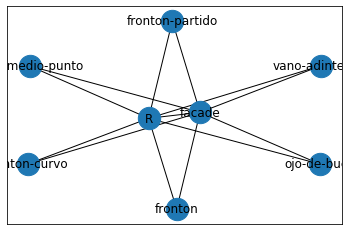

In [7]:
facade_dic = { key_interest: index_dic[key_interest] for key_interest in list(FG.nodes) }
nx.draw_networkx(FG, node_size=500, labels=facade_dic, with_labels=True, label="FG graph")

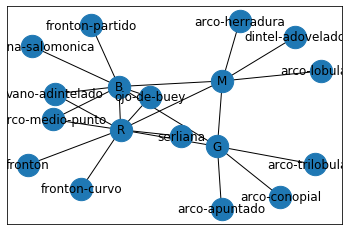

In [8]:
KG_dic = { key_interest: index_dic[key_interest] for key_interest in list(KG.nodes) }
nx.draw_networkx(KG, node_size=500, labels=KG_dic, with_labels=True, label="KG graph")

In [9]:
sub_KG = filter_KG(KG,FG)

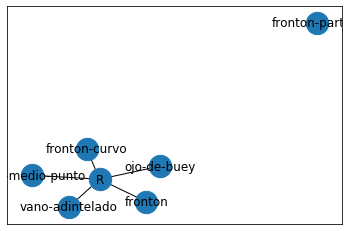

In [10]:
sub_KG_dic = { key_interest: index_dic[key_interest] for key_interest in list(sub_KG.nodes) }
nx.draw_networkx(sub_KG, node_size=500, labels=sub_KG_dic, with_labels=True, label="sub KG graph")

In [11]:
d = distance(sub_KG, FG)

In [12]:
d - edge_count

1.0